In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from operator import itemgetter

In [2]:
def gru(path, train_test_split_ratio, gru_config, figsize=(40, 15), seq_len=(1,14), attribute='Close'):
    df = pd.read_csv(path)
    display(df.head())

    train_set, test_set = train_test_split(df, test_size=train_test_split_ratio, shuffle=False)

    test_dates = pd.to_datetime(test_set['Date'])

    epochs, batch_size, dropout = itemgetter('epochs', 'batch_size', 'dropout')(gru_config)

    #Variables for training
    cols = list(df)[1:6]
    df_for_training = train_set[cols].astype(float)
    df_for_testing = test_set[cols].astype(float)

    trainX, trainY = [], []
    testX, testY = [], []

    #GRU uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
    # normalize the dataset
    scaler = StandardScaler()
    scaler = scaler.fit(df_for_training)
    df_for_training_scaled = scaler.transform(df_for_training)
    df_for_testing_scaled = scaler.transform(df_for_testing)

    n_future = seq_len[0]   # Number of days we want to look into the future based on the past days.
    n_past = seq_len[1]  # Number of past days we want to use to predict the future.

    testY_cutoff = test_dates[test_dates.index[0] + n_past]

    index_cutoff = test_dates.index[0] + n_past

    print(f'testY_cutoff is {testY_cutoff}')

    attribute_to_col_map = {
        'Open': 0,
        'High': 1,
        'Low': 2,
        'Close': 3,
        'Adj Close': 4
    }

    column = attribute_to_col_map[attribute]

    # slice the training set
    for i in range(n_past, len(df_for_training_scaled) - n_future +1):
        trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
        trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, column])

    # slice the testing set
    for i in range(n_past, len(df_for_testing_scaled) - n_future +1):
        testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing.shape[1]])
        testY.append(df_for_testing_scaled[i + n_future - 1:i + n_future, column])

    trainX, trainY = np.array(trainX), np.array(trainY)
    testX, testY = np.array(testX), np.array(testY)

    # create the model
    model = Sequential()
    model.add(GRU(64, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))

    model.add(GRU(32, activation='tanh', return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(trainY.shape[1]))

    model.compile(optimizer='adam', loss='mae')
    model.summary()

    # fit the model
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()

    #Make prediction
    predictions = model.predict(testX) 

    predictions_copies = np.repeat(predictions, df_for_training.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(predictions_copies)[:,0]

    original = df[['Date', attribute]]
    original['Date']=pd.to_datetime(original['Date'])
    original = original.loc[original['Date'] >= testY_cutoff]

    df_forecast = pd.DataFrame(columns=['Date', attribute])
    df_forecast['Date'] = test_dates
    df_forecast = df_forecast.loc[df_forecast['Date'] >= testY_cutoff]
    df_forecast[attribute] = y_pred_future

    complete = df[['Date', attribute]]
    complete['Date']=pd.to_datetime(complete['Date'])



    plt.figure(figsize=figsize)
    plt.plot(range(0, 9909), complete[attribute].to_list(), 'r', label='Label 1')
    plt.plot(range(index_cutoff, 9909), df_forecast[attribute].to_list(), 'g', label='Label 2')
    plt.plot(range(index_cutoff, 9909), original[attribute].to_list(), 'b', label='Label 3')

    return {
        'forecast': df_forecast,
        'original': original,
        'complete': complete
    }

In [3]:
path = '../dataset/stocks/AAPL.csv'
train_test_split_ratio = 0.3

In [4]:
lstm_config = {
    'epochs': 5,
    'batch_size': 16,
    'dropout': 0.2
}

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


testY_cutoff is 2008-07-01 00:00:00
Model: "sequential"
_________________________________________________________________


2022-12-12 00:29:58.817037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14, 64)            13632     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 23,073
Trainable params: 23,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
390/390 [==============================] - 5s 9ms/step - loss: 0.0367 - val_loss: 0.8135
Epoch 2/5
390/390 [==============================] - 3s 8ms/step - loss: 0.0271 - val_loss: 0.7142
Epoch 3/5
390/390 [==============================] - 3s 7ms/step - loss:

/var/folders/sc/8hkgz59j2vd4q223kqjgwh6h0000gn/T/ipykernel_81562/47879900.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
/var/folders/sc/8hkgz59j2vd4q223kqjgwh6h0000gn/T/ipykernel_81562/47879900.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete['Date']=pd.to_datetime(complete['Date'])


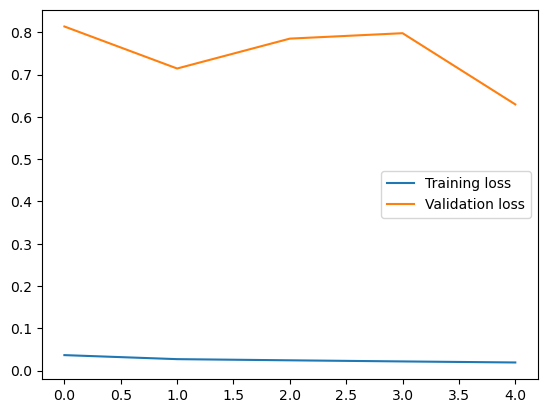

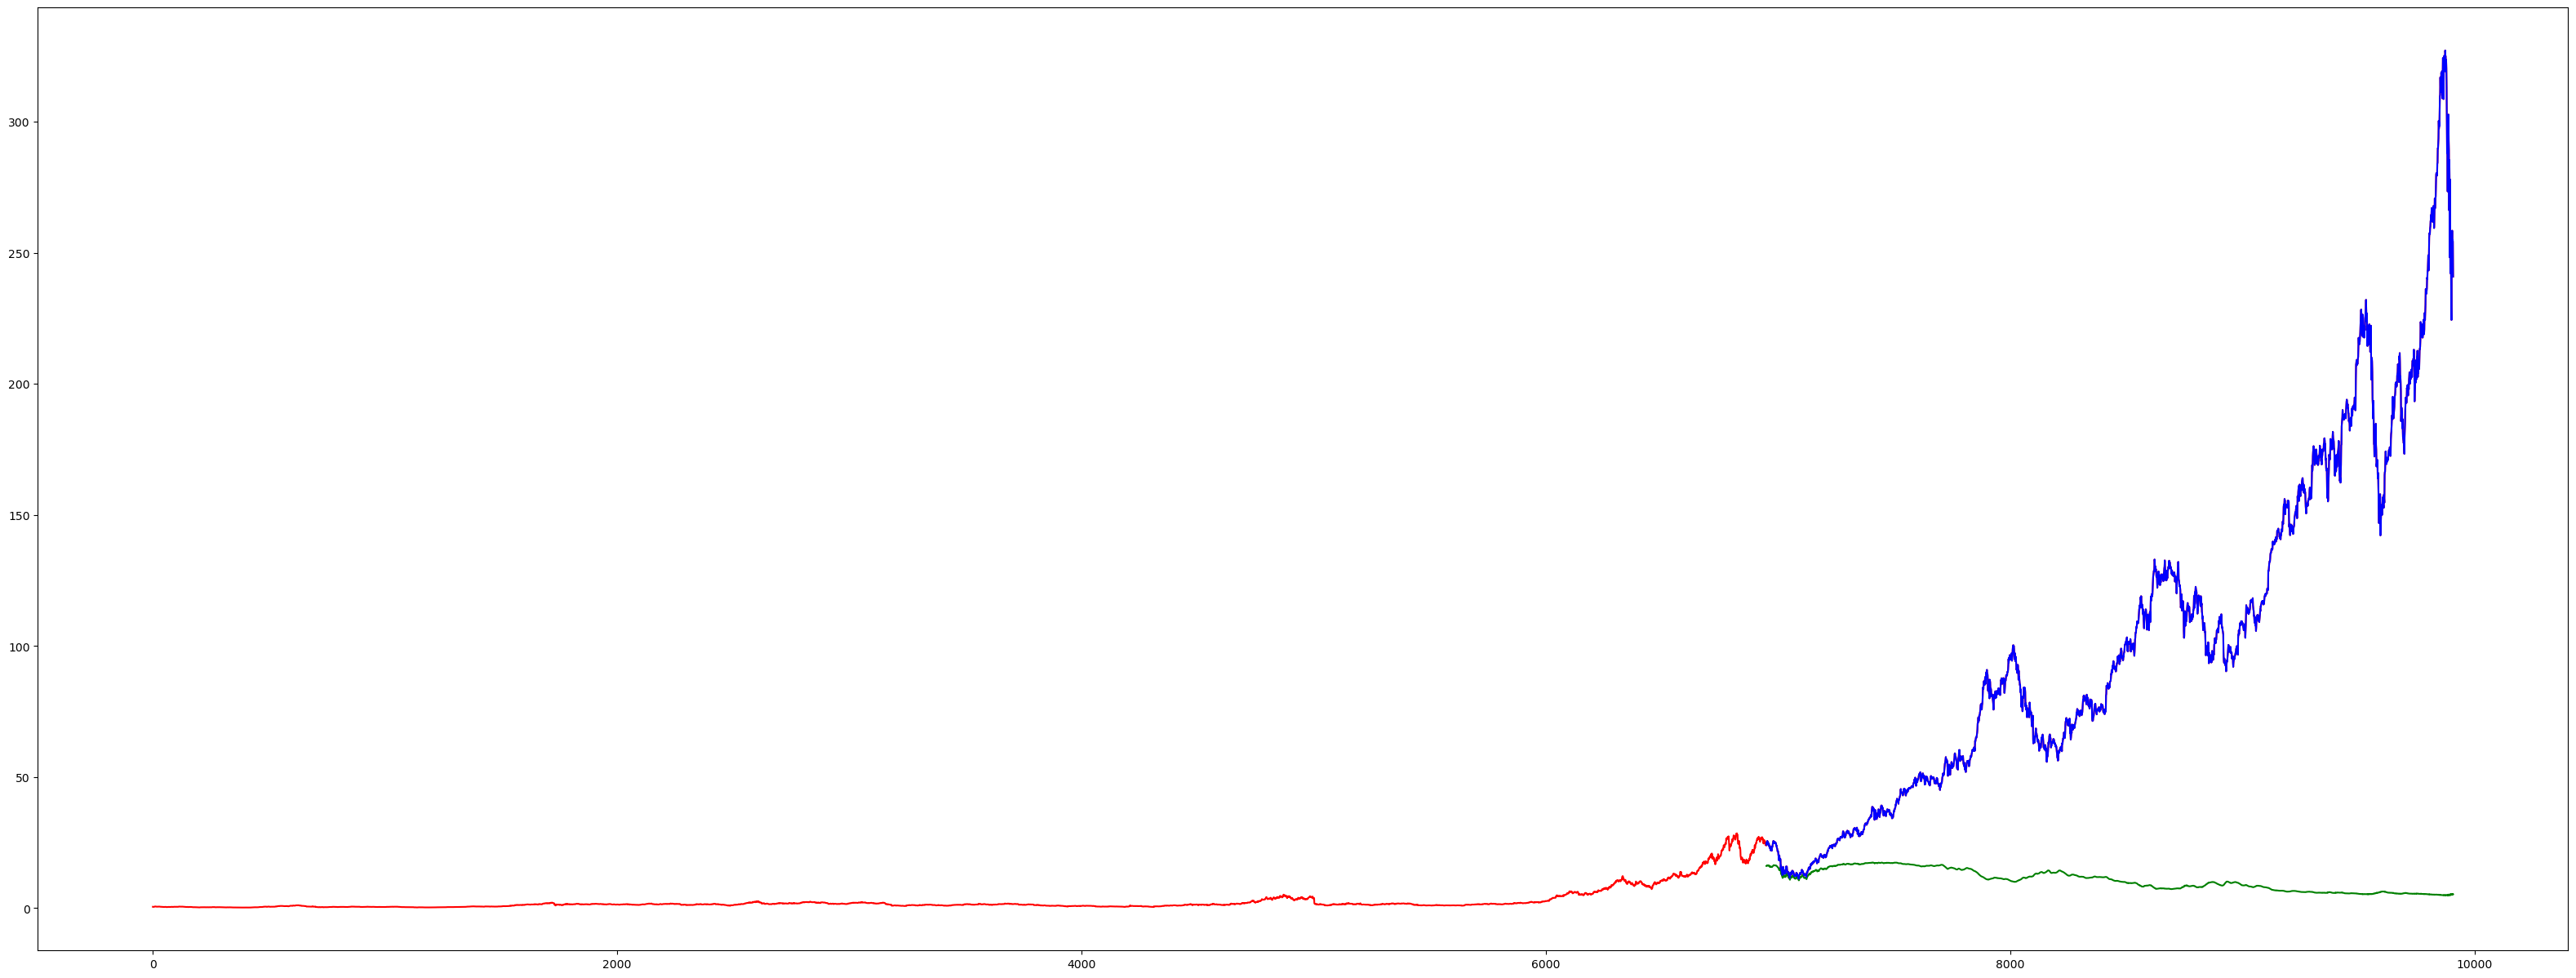

In [5]:
results = gru(path, train_test_split_ratio, lstm_config, (40, 15), (1, 14))